# Programming Assignment #3: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Know what Python generators are
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the sort of flower in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `5.4-visualizing-what-convnets-learn.ipynb`. The version available here https://github.com/fchollet/deep-learning-with-python-notebooks does not work with TensorFlow 2. Use the implementation available here: https://github.com/pnugues/edan95/tree/master/labs instead.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU. This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. You will collect a dataset from Kaggle (https://www.kaggle.com/). First register, it is free, and you will have access to lots of datasets.
2. Download the Flower corpus (https://www.kaggle.com/alxmamaev/flowers-recognition). You can find a local copy in the `/usr/local/cs/EDAN95/datasets` folder.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
 * Start with the partition available in the `/usr/local/cs/EDAN95/datasets` folder; or
 * You can also run the code in the cells below (recommended).


In [ ]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name
machine_name = 'colab'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [ ]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'pierre':
    base = '/Users/pierre/Documents/Cours/EDAN95/datasets/'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = 'your folder'

In [ ]:
os.chdir(base)
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/110472418_87b6a3aa98_m.jpg  
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b

In [ ]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


['/content/drive/My Drive/Colab Notebooks/flowers/daisy',
 '/content/drive/My Drive/Colab Notebooks/flowers/dandelion',
 '/content/drive/My Drive/Colab Notebooks/flowers/rose',
 '/content/drive/My Drive/Colab Notebooks/flowers/sunflower',
 '/content/drive/My Drive/Colab Notebooks/flowers/tulip']

We build the (image, label) pairs

In [ ]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('1031799732_e7f4008c03.jpg', 'daisy'),
 ('10140303196_b88d3d6cec.jpg', 'daisy'),
 ('10172636503_21bededa75_n.jpg', 'daisy'),
 ('102841525_bd6628ae3c.jpg', 'daisy'),
 ('10172567486_2748826a8b.jpg', 'daisy'),
 ('10300722094_28fa978807_n.jpg', 'daisy'),
 ('10172379554_b296050f82_n.jpg', 'daisy'),
 ('100080576_f52e8ee070_n.jpg', 'daisy'),
 ('10993710036_2033222c91.jpg', 'daisy'),
 ('10391248763_1d16681106_n.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [ ]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    # print(train_images)
    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

2595
865
866


We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [ ]:
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

100%|██████████| 866/866 [00:09<00:00, 91.99it/s]


## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

Create the network and compile it

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Create now the data generators for the training, validation, and test set

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


Found 2592 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 5)


Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS`

In [ ]:
import math
STEPS_PER_EPOCH = math.ceil(2592/20)
VALIDATION_STEPS = math.ceil(865/20)

And fit your model

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)


Epoch 1/30
130/130 [==============================] - 117s 896ms/step - loss: 1.4016 - acc: 0.4151 - val_loss: 1.3753 - val_acc: 0.4451
Epoch 2/30
130/130 [==============================] - 117s 901ms/step - loss: 1.0673 - acc: 0.5795 - val_loss: 0.9953 - val_acc: 0.6208
Epoch 3/30
130/130 [==============================] - 114s 880ms/step - loss: 0.9248 - acc: 0.6508 - val_loss: 0.9255 - val_acc: 0.6393
Epoch 4/30
130/130 [==============================] - 115s 882ms/step - loss: 0.7926 - acc: 0.7045 - val_loss: 0.8667 - val_acc: 0.6728
Epoch 5/30
130/130 [==============================] - 114s 878ms/step - loss: 0.6791 - acc: 0.7504 - val_loss: 0.9156 - val_acc: 0.6671
Epoch 6/30
130/130 [==============================] - 115s 888ms/step - loss: 0.5534 - acc: 0.8005 - val_loss: 1.0287 - val_acc: 0.6532
Epoch 7/30
130/130 [==============================] - 115s 881ms/step - loss: 0.4267 - acc: 0.8565 - val_loss: 1.1535 - val_acc: 0.6751
Epoch 8/30
130/130 [============================

### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

In [ ]:
model.save('flowers_model_1.h5')


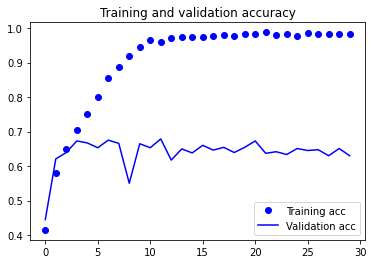

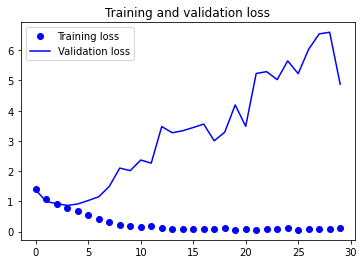

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
os.chdir(base)
model = models.load_model('flowers_model_1.h5')

### Predicting the test set

Apply now your network to the test set

In [ ]:
TEST_STEPS = math.ceil(866/20)
predict = model.predict(test_generator,steps = TEST_STEPS)
predict

array([[2.24100216e-03, 4.13569156e-03, 6.89070970e-02, 9.10576642e-01,
        1.41396476e-02],
       [9.99999523e-01, 2.28590369e-10, 1.08634648e-08, 6.21996642e-18,
        4.87492343e-07],
       [9.45731163e-01, 1.47569086e-08, 5.42688407e-02, 1.32877620e-08,
        2.82344027e-13],
       ...,
       [3.13131458e-25, 0.00000000e+00, 5.21751899e-05, 5.36360429e-21,
        9.99947786e-01],
       [1.12664774e-13, 9.40438398e-24, 1.26130199e-13, 1.00000000e+00,
        1.27929480e-08],
       [9.77941573e-01, 2.68944702e-03, 1.30561317e-12, 1.55075966e-07,
        1.93687361e-02]], dtype=float32)

In [ ]:
predicted_labels = list(map(np.argmax, predict))
true_labels = test_generator.classes
print(predicted_labels)
print(true_labels)

[3, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 3, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 4, 1, 0, 0, 0, 0, 4, 0, 0, 1, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 1, 0, 1, 1, 4, 1, 1, 3, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 3, 0, 0, 0, 1, 1, 2, 3, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 2, 3, 1, 4, 3, 1, 1, 1, 1, 4, 1, 1, 1, 0, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 3, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 4, 3, 0, 1, 0, 1, 3, 0, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Report the accuracy as well as the classification report. Use sklearn functions

In [ ]:

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print("Classification report for classifier %s:\n%s\n"
      % (model, classification_report(true_labels, predicted_labels)))
print(accuracy_score(true_labels, predicted_labels))



Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb12c7a3c88>:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       146
           1       0.73      0.71      0.72       210
           2       0.56      0.47      0.51       156
           3       0.66      0.74      0.70       137
           4       0.64      0.58      0.61       217

    accuracy                           0.64       866
   macro avg       0.63      0.64      0.63       866
weighted avg       0.64      0.64      0.64       866


0.6385681293302541


Print the confusion matrix

In [ ]:
print("Confusion matrix:\n%s" % confusion_matrix(true_labels, predicted_labels))


Confusion matrix:
[[103  23   4   9   7]
 [ 20 150   7  25   8]
 [ 20   9  74   4  49]
 [ 13  15   3 101   5]
 [ 24   9  45  14 125]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [ ]:
test_loss_1, test_acc_1 = model.evaluate(test_generator, batch_size=20)
print(test_loss_1, test_acc_1)

44/44 [==============================] - 12s 264ms/step - loss: 4.6252 - acc: 0.6386
4.625234127044678 0.638568103313446


Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

['/content/drive/My Drive/Colab Notebooks/flowers_split/train/daisy/17101762155_2577a28395.jpg', '/content/drive/My Drive/Colab Notebooks/flowers_split/train/daisy/5693459303_e61d9a9533.jpg', '/content/drive/My Drive/Colab Notebooks/flowers_split/train/daisy/14372713423_61e2daae88.jpg']


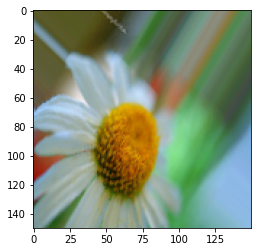

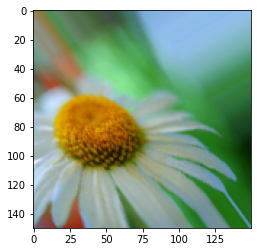

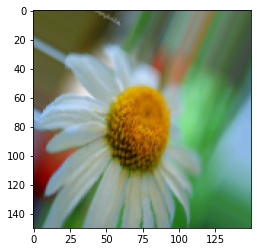

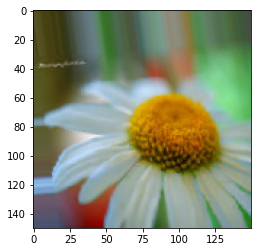

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

from keras.preprocessing import image

fnames = [os.path.join(os.path.join(train_dir, label_dir),image) for label_dir in os.listdir(train_dir) for image in os.listdir(os.path.join(train_dir, label_dir))]
print(fnames[0:3])
# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['acc'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

Fit a model. You reset the model by recreating it.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)
os.chdir(base)
model.save('flowers_model_2.h5')

Epoch 1/30
130/130 [==============================] - 1530s 12s/step - loss: 1.5115 - acc: 0.3580 - val_loss: 1.4498 - val_acc: 0.4104
Epoch 2/30
130/130 [==============================] - 140s 1s/step - loss: 1.1931 - acc: 0.4988 - val_loss: 1.6014 - val_acc: 0.4081
Epoch 3/30
130/130 [==============================] - 131s 1s/step - loss: 1.0655 - acc: 0.5899 - val_loss: 0.9344 - val_acc: 0.6208
Epoch 4/30
130/130 [==============================] - 145s 1s/step - loss: 0.9857 - acc: 0.6273 - val_loss: 1.0083 - val_acc: 0.6081
Epoch 5/30
130/130 [==============================] - 140s 1s/step - loss: 0.9549 - acc: 0.6308 - val_loss: 0.8159 - val_acc: 0.6855
Epoch 6/30
130/130 [==============================] - 131s 1s/step - loss: 0.9059 - acc: 0.6543 - val_loss: 0.8473 - val_acc: 0.6405
Epoch 7/30
130/130 [==============================] - 127s 975ms/step - loss: 0.8936 - acc: 0.6674 - val_loss: 0.8547 - val_acc: 0.6867
Epoch 8/30
130/130 [==============================] - 125s 964ms

OSError: ignored

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

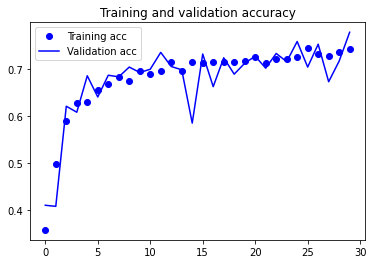

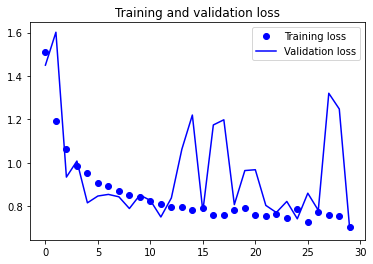

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [ ]:
model = models.load_model('flowers_model_2.h5')
test_loss_2, test_acc_2 = model.evaluate(test_generator)
print(test_loss_2, test_acc_2)

44/44 [==============================] - 12s 274ms/step - loss: 0.6553 - acc: 0.7806
0.6553162336349487 0.7806004881858826


## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [ ]:
from keras.applications import VGG16, InceptionV3

In [ ]:
PRETRAINED = 'VGG'
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet')
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count,5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

The features and labels

In [ ]:
BATCH_SIZE_TRAIN = 2592
BATCH_SIZE_VAL =  865
BATCH_SIZE_TEST = 866
train_features, train_labels = extract_features(train_dir, BATCH_SIZE_TRAIN)
validation_features, validation_labels = extract_features(validation_dir, BATCH_SIZE_VAL)
test_features, test_labels = extract_features(test_dir, BATCH_SIZE_TEST)

Found 2592 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 866 images belonging to 5 classes.


In [ ]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2593, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (865, 4 * 4 * 512)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (865, 4 * 4 * 512))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 2048))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=OPTIMIZER,
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 4,720,133
Trainable params: 4,720,133
Non-trainable params: 0
_________________________________________________________________


Fit your network

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

model.save('flowers_model_3.h5')


Epoch 1/30
130/130 [==============================] - 4s 34ms/step - loss: 5.7072 - acc: 0.6119 - val_loss: 6.0786 - val_acc: 0.4590
Epoch 2/30
130/130 [==============================] - 4s 33ms/step - loss: 1.3133 - acc: 0.7658 - val_loss: 1.2209 - val_acc: 0.7179
Epoch 3/30
130/130 [==============================] - 4s 34ms/step - loss: 0.8929 - acc: 0.8086 - val_loss: 1.3171 - val_acc: 0.7734
Epoch 4/30
130/130 [==============================] - 4s 33ms/step - loss: 0.7732 - acc: 0.8534 - val_loss: 1.3980 - val_acc: 0.7769
Epoch 5/30
130/130 [==============================] - 4s 34ms/step - loss: 0.4138 - acc: 0.9043 - val_loss: 2.0668 - val_acc: 0.7075
Epoch 6/30
130/130 [==============================] - 4s 34ms/step - loss: 0.4268 - acc: 0.9128 - val_loss: 1.6127 - val_acc: 0.7815
Epoch 7/30
130/130 [==============================] - 4s 34ms/step - loss: 0.2201 - acc: 0.9483 - val_loss: 1.8411 - val_acc: 0.7595
Epoch 8/30
130/130 [==============================] - 4s 34ms/step - 

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

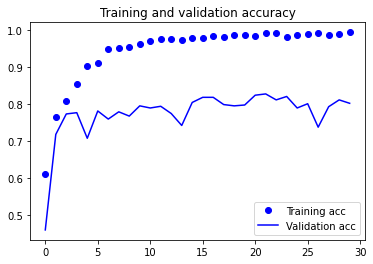

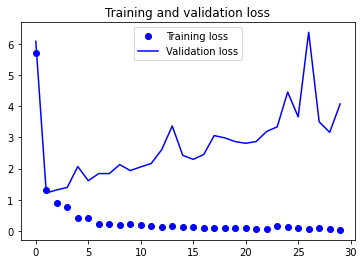

In [ ]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [ ]:
model = models.load_model('flowers_model_3.h5')
predict = model.predict(test_features)
predicted_labels = list(map(np.argmax, predict))
true_labels = list(map(np.argmax, test_labels))
print(predicted_labels)
print(true_labels)

[3, 3, 4, 1, 4, 3, 2, 0, 4, 2, 1, 4, 4, 4, 0, 1, 4, 1, 4, 3, 4, 1, 4, 4, 3, 1, 1, 1, 3, 2, 2, 0, 1, 4, 4, 1, 2, 4, 3, 1, 4, 4, 2, 1, 4, 3, 0, 3, 1, 3, 2, 0, 0, 4, 3, 4, 4, 1, 1, 0, 0, 3, 2, 3, 4, 0, 1, 4, 4, 4, 1, 1, 4, 1, 1, 2, 4, 4, 0, 2, 2, 4, 4, 1, 4, 4, 4, 1, 1, 0, 0, 3, 4, 4, 1, 1, 4, 0, 4, 4, 3, 0, 2, 1, 1, 3, 4, 4, 1, 4, 2, 4, 4, 1, 1, 1, 2, 1, 2, 3, 1, 0, 3, 4, 3, 1, 0, 3, 0, 1, 2, 2, 0, 1, 0, 2, 1, 2, 3, 4, 3, 4, 0, 2, 1, 1, 0, 1, 0, 3, 1, 4, 3, 4, 4, 1, 0, 0, 3, 4, 4, 2, 4, 4, 1, 4, 0, 3, 2, 1, 1, 0, 3, 3, 4, 4, 4, 1, 2, 0, 0, 4, 1, 1, 4, 4, 3, 1, 4, 1, 4, 2, 3, 2, 4, 4, 4, 3, 3, 1, 4, 0, 0, 3, 0, 4, 4, 2, 1, 4, 0, 4, 3, 0, 3, 3, 1, 3, 0, 2, 1, 2, 2, 4, 3, 0, 4, 1, 0, 1, 1, 4, 1, 4, 3, 4, 1, 4, 0, 2, 1, 1, 2, 0, 0, 4, 4, 4, 2, 3, 4, 1, 4, 3, 0, 1, 2, 4, 0, 3, 3, 0, 1, 1, 4, 0, 3, 4, 1, 1, 1, 3, 1, 0, 4, 0, 2, 4, 1, 1, 1, 4, 1, 0, 0, 1, 2, 4, 3, 2, 4, 4, 3, 2, 2, 0, 0, 1, 1, 4, 3, 4, 2, 4, 4, 1, 4, 0, 4, 1, 2, 4, 2, 2, 1, 4, 0, 4, 4, 0, 3, 0, 4, 0, 1, 0, 3, 4, 3, 1, 4, 2, 3, 

Report the accuracy as well as the classification report. Use sklearn functions

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print("Classification report for classifier %s:\n%s\n"
      % (model, classification_report(true_labels, predicted_labels)))
#classification_report(true_labels, predicted_labels)
print(accuracy_score(true_labels, predicted_labels))

Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb0f16699e8>:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       146
           1       0.87      0.93      0.90       210
           2       0.88      0.59      0.71       156
           3       0.87      0.74      0.80       137
           4       0.68      0.89      0.77       217

    accuracy                           0.81       866
   macro avg       0.83      0.79      0.80       866
weighted avg       0.82      0.81      0.80       866


0.8060046189376443


Print the confusion matrix

In [ ]:
print("Confusion matrix:\n%s" % confusion_matrix(true_labels, predicted_labels))

Confusion matrix:
[[117   7   0   5  17]
 [  7 195   0   3   5]
 [  2   4  92   6  52]
 [  6  11   3 101  16]
 [  6   8   9   1 193]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [ ]:
test_loss_3, test_acc_3 = model.evaluate(test_features, test_labels)
print(test_loss_3, test_acc_3)

28/28 [==============================] - 0s 10ms/step - loss: 3.7426 - acc: 0.8060
3.7426416873931885 0.8060046434402466


## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [ ]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

conv_base.trainable = False


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 26,522,917
Trainable params: 26,488,485
Non-trainable params: 34,432
_________________________________________________________________


Create the generators

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 2592 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 5)


Fit the model

In [ ]:
#sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['acc'])

import math
STEPS_PER_EPOCH = math.ceil(2592/20)
VALIDATION_STEPS = math.ceil(865/20)
history = model.fit(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=VALIDATION_STEPS)


Epoch 1/30
130/130 [==============================] - 156s 1s/step - loss: 6.5727 - acc: 0.5494 - val_loss: 2.5502 - val_acc: 0.6543
Epoch 2/30
130/130 [==============================] - 152s 1s/step - loss: 1.5836 - acc: 0.7002 - val_loss: 0.8654 - val_acc: 0.7526
Epoch 3/30
130/130 [==============================] - 151s 1s/step - loss: 1.1001 - acc: 0.7207 - val_loss: 1.0206 - val_acc: 0.7480
Epoch 4/30
130/130 [==============================] - 152s 1s/step - loss: 0.8065 - acc: 0.7442 - val_loss: 0.6846 - val_acc: 0.7757
Epoch 5/30
130/130 [==============================] - 152s 1s/step - loss: 0.7101 - acc: 0.7677 - val_loss: 0.6692 - val_acc: 0.7561
Epoch 6/30
130/130 [==============================] - 153s 1s/step - loss: 0.6874 - acc: 0.7840 - val_loss: 1.1343 - val_acc: 0.7214
Epoch 7/30
130/130 [==============================] - 152s 1s/step - loss: 0.6500 - acc: 0.7955 - val_loss: 0.8770 - val_acc: 0.7595
Epoch 8/30
130/130 [==============================] - 155s 1s/step - 

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

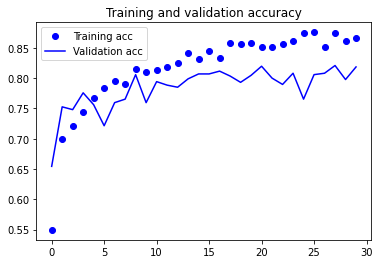

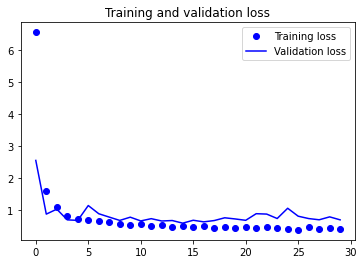

In [ ]:
model.save('flowers_model_4.h5')
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predicting the test set

Apply now your network to the test set

In [ ]:
model = models.load_model('flowers_model_4.h5')
TEST_STEPS = math.ceil(866/20)
predict = model.predict(test_generator,steps = TEST_STEPS)
print(predict)
predicted_labels = list(map(np.argmax, predict))
true_labels = test_generator.classes
print(predicted_labels)
print(true_labels)

[[5.2951306e-01 3.7643489e-01 3.4327265e-02 1.5773164e-02 4.3951552e-02]
 [1.0000000e+00 1.2432250e-11 5.4329229e-17 4.3959973e-14 3.4567648e-16]
 [9.9060726e-01 1.4969915e-05 2.0868298e-05 9.3554985e-03 1.2531801e-06]
 ...
 [2.0693656e-06 1.0046812e-07 2.1545650e-03 3.1070872e-06 9.9784017e-01]
 [1.3807787e-04 3.3825305e-05 1.7715672e-02 8.8243848e-03 9.7328806e-01]
 [2.1650395e-01 3.3892876e-01 1.2618306e-02 2.3941869e-01 1.9253033e-01]]
[0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 1, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 3, 4, 2, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 2, 0, 0, 4, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 1, 3, 1, 0, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 

Report the accuracy as well as the classification report. Use sklearn functions

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print("Classification report for classifier %s:\n%s\n"
      % (model, classification_report(true_labels, predicted_labels)))
#classification_report(true_labels, predicted_labels)
print(accuracy_score(true_labels, predicted_labels))

Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb0ee2f2710>:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       146
           1       0.92      0.86      0.89       210
           2       0.79      0.76      0.77       156
           3       0.79      0.84      0.82       137
           4       0.79      0.85      0.82       217

    accuracy                           0.83       866
   macro avg       0.82      0.82      0.82       866
weighted avg       0.83      0.83      0.83       866


0.825635103926097


Print the confusion matrix

In [ ]:
print("Confusion matrix:\n%s" % confusion_matrix(true_labels, predicted_labels))

Confusion matrix:
[[118   3   5  10  10]
 [ 13 180   1   9   7]
 [  2   3 118   6  27]
 [  6   5   7 115   4]
 [  5   4  19   5 184]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [ ]:
test_loss_4, test_acc_4 = model.evaluate(test_generator, batch_size=20)
print(test_loss_4, test_acc_4)

44/44 [==============================] - 34s 777ms/step - loss: 0.6124 - acc: 0.8256
0.6124193072319031 0.8256350755691528


## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [ ]:
(test_loss_1, test_acc_2), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((4.625234127044678, 0.7806004881858826),
 (0.6553162336349487, 0.7806004881858826),
 (3.7426416873931885, 0.8060046434402466),
 (0.6124193072319031, 0.8256350755691528))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe the architectures you designed and the results you obtained;
2. You will run Chollet's notebook 5.4 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. 
3. You will run it on one of your images.

You will submit this report through Canvas.

In [ ]:
#os.chdir(base)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

In [ ]:
from tensorflow.keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
import numpy as np

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')



# The local path to our target image
img_path = '/content/drive/My Drive/Colab Notebooks/flowers/daisy/1031799732_e7f4008c03.jpg'
#img_path = 'flowers/sunflower/8174972548_0051c2d431.jpg'
#img_path = 'flowers/rose/110472418_87b6a3aa98_m.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n11939491', 'daisy', 0.99213845), ('n02219486', 'ant', 0.0022629665), ('n02206856', 'bee', 0.0010182504)]


In [ ]:
import tensorflow as tf
ind = np.argmax(preds[0])

# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, ind]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
feature_extractor = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
with tf.GradientTape() as tape:
    conv_layer_output_value, predictions = feature_extractor(x)
    loss = predictions[:, ind]
grads = tape.gradient(loss, conv_layer_output_value)

pooled_grads = K.mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
#for i in range(512):
#    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
conv_layer_output_value = tf.multiply(pooled_grads, conv_layer_output_value[0])
print(conv_layer_output_value.shape)

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
print(heatmap.shape)

(14, 14, 512)
(14, 14)


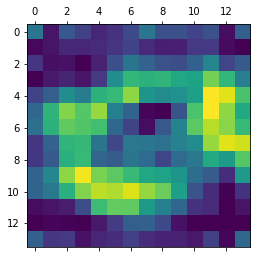

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

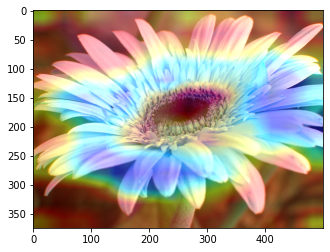

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)/255.
plt.imshow(img)
# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
plt.imshow(heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4/255. + img 
plt.imshow(superimposed_img)
# Save the image to disk
cv2.imwrite('daisy_heatmap.jpg', 255*superimposed_img)

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     